# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.14 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# set random seeds
# Seed
SEED=1211
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# device info
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [6]:
# environment details
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)
print('Size of state:', state_size)
print('Size of action:', action_size)
# number of agents in the environment
print('Number of agents:', len(env_info.agents))
# examine the state space 
print('States look like:', state)

Size of state: 37
Size of action: 4
Number of agents: 1
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]


### 3. Introduction
Double DQN is one of the improvements over Vanilla DQNs.It was first discussed on paper [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461) which was introduced in 2015 by Google Deepmind Team. Double network address two problems with vanilla deep Q learning.

1. **Moving Target**: Because same network is responsible for both the choosing actions and evaluating of actions, this leads to training instability.  


2. **Overfitting over expirences**: In vanilla DQN, while training the network we feed them the immediate expirences which are highly co-releated, network tends to explore less and become bais towards the immediate expirence.

DQN algorithm attempts to find a policy $\pi$ which maps a given state $s_t$ to an action at such that it maximizes the expected reward of the agent $\mathbb{E}_{\pi}\Big[ \sum_{t=0}^\infty r_t \Big]$ from some starting state $s_0$. DQN obtains $\pi$ implicitly by calculating a state-value function $Q_θ(s,a)$ parameterized by θ, which measures the goodness of the given state-action with respect to some behavioral policy.

To find an appropriate θ, which then determines the final policy $\pi$, DQN performs the following optimization:

<center>
$
{\rm minimize}_{\theta} \;\; \mathbb{E}_{(s_t,a_t,r_t,s_{t+1})\sim D}
\left[
\Big(r_t + \gamma \max_{a \in \mathcal{A}} Q_{\theta^-}(s_{t+1},a) - Q_\theta(s_t,a_t)\Big)^2
\right]
$
</center>


where $(s_t,a_t,r_t,s_{t+1})$ are batches of samples from the replay buffer $D$, which is designed to store the past N samples. In addition, $A$ represents the set of discrete actions, θ is the local network and $\theta^-$ represents the target network. Both networks use the same architecture, and we use $Q_θ(s,a)$ or $Q_{\theta^-}(s,a)
$ to denote which of the two is being applied to evaluate (s,a).

The target network starts off by getting matched to the current network, but remains frozen (usually for thousands of steps) before getting updated again to match the network. The process repeats throughout training, with the goal of increasing the stability of the targets $r_t + \gamma \max_{a \in \mathcal{A}}Q_{\theta^-}(s_{t+1},a)$.

Network is trained same as Vanilla Q-Network

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQNetwork(nn.Module):
    """ Deep Q-Network """
    
    def __init__(self, state_size, action_size, fc1_size=64, fc2_size=64):
        """Initialize parameters and fc model.
        Params
        ======
            state_size : Dimension of each state
            action_size : Dimension of each action
            seed : Random seed
            fc1_size : Number of nodes in first hidden layer
            fc2_size : Number of nodes in second hidden layer
        """
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 5. Replay Buffer
Fixed-size circular queue which stores the experience tuples. Help us collect expirence samples randomly which breaks the dependency over sequential expirence.  

In [8]:
import numpy as np
import random
from collections import namedtuple, deque
import torch

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self, batch_size, device):

        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.buffer, k=batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)

### 6. Agent
![Double DQN](../images/double_dqn.png)

In [9]:

class DDQNAgent():

    def __init__(self, state_size, action_size, gamma=0.99, learning_rate=3e-4, buffer_size=10000, batch_size=64, tau=1e-3, update_every=4):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            gamma (float): discount factor
            learning_rate (float): learning rate
            buffer_size (int): replay buffer size
            batch_size (int):  minibatch size
            tau (float):  interpolation parameter for soft update
            update_every (float):  how frequently network should be updated
        """
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.buffer_size = buffer_size;
        self.batch_size = batch_size;
        self.gamma = gamma
        self.update_every = update_every
        self.tau = tau
        self.lr = learning_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Q-Network
        self.qnetwork_local = DQNetwork(state_size, action_size).to(self.device)
        self.qnetwork_target = DQNetwork(state_size, action_size).to(self.device)
        self.optimizer = torch.optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)

        # Replay memory
        self.buffer = ReplayBuffer(self.buffer_size)

        # time step
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.buffer.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % self.update_every
        # If enough samples are available in memory, get random subset and learn
        if self.t_step == 0 and len(self.buffer) > self.batch_size:
            experiences = self.buffer.sample(self.batch_size, self.device)
            self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values from target model
        best_action_local = self.qnetwork_local(states).max(1)[1].unsqueeze(1)
        q_action_targets = self.qnetwork_target(next_states)
        q_targets_next = torch.gather(q_action_targets, 1, best_action_local)

        # Compute Q targets for current states 
        q_targets = rewards + (gamma * q_targets_next * (1 - dones))

        # Get expected Q values from local model
        q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(q_expected, q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Soft update params
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def print(self):
        num_parameters_local = sum([params.numel() for params in self.qnetwork_local.parameters() if params.requires_grad])
        num_parameters_target = sum([params.numel() for params in self.qnetwork_target.parameters() if params.requires_grad])
        total_params = num_parameters_local + num_parameters_target
        print(self.qnetwork_local)
        print(f"Number of parameters in model : {total_params}")

### 7. Initialize Agent

In [10]:
# Hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
GAMMA = 0.99            # discount factor
LR = 5e-3               # learning rate 
BATCH_SIZE = 64         # minibatch size
eps_start=1.0
eps_decay=.995
eps_min=0.05
n_episodes = 1000
max_t = 2000
TAU= 1e-3 
UPDATE_EVERY=4


agent = DDQNAgent(state_size, action_size)
agent.print()

DQNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Number of parameters in model : 13704


### 8. Train

In [11]:
def train(agent, n_episodes, max_t, eps_start, eps_min, eps_decay):

    scores = []                                               # list containing scores from each episode                 
    scores_window = deque(maxlen=100)                         # store only the last 100 scores
    eps = eps_start                                           # initialize epsilon (for epsilon-greedy policy)
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        state = env_info.vector_observations[0]               # get the initial state
        score = 0                                             # initialize the score

        for t in range(max_t):                                # run for maximum of max_t timesteps 
            action = agent.act(state, eps)                    # select the action
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]      # get the state
            reward = env_info.rewards[0]                      # get the reward
            done = env_info.local_done[0]                     # whether the episode is complete or not
            agent.step(state, action, reward, next_state, done)  # train the agent 
            score += reward                                      # update the score
            
            state = next_state                                   # update the state
            if done:                                             # break if episode is complete
                break
        
        scores_window.append(score)                # update the window of scores
        scores.append(score)                       # update the list of scores
        eps = max(eps_min, eps * eps_decay)        # modify epsilon
        average_score = np.mean(scores_window)
        print('\rEpisode {} \tAverage score: {: .2f}'.format(i_episode, average_score), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {} \tAverage score: {: .2f}'.format(i_episode, average_score))
            
    return scores

### 9. Start training

Episode 100 	Average score:  1.03
Episode 200 	Average score:  4.53
Episode 300 	Average score:  7.51
Episode 400 	Average score:  10.16
Episode 500 	Average score:  11.45
Episode 600 	Average score:  13.62
Episode 700 	Average score:  13.71
Episode 800 	Average score:  13.23
Episode 900 	Average score:  15.00
Episode 1000 	Average score:  14.32


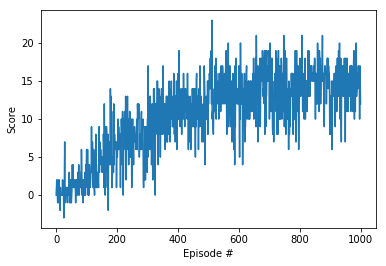

In [12]:
# train the model
scores = train(agent, n_episodes, max_t, eps_start, eps_min, eps_decay)
# save model
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint/double_dqn.pth')

import matplotlib.pyplot as plt
%matplotlib inline
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('results/double_dqn_result.png', bbox_inches='tight')
plt.show()

### 10. Model in action

In [13]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint/double_dqn.pth'))
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 15.0


In [14]:
env.close()